# Sheraton Expansion

Sheraton Hotel desires to expand into US states that it is not already present. It wants to become a familiar face to people of those states so they feel more comfortable rooming with Sheraton when they travel and to have a new vacation spot available for current Sheraton members. They want to know where the next best place to put their newest hotel would be and why.

In [859]:
#Reading in packages

import requests
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

! pip install geopy
from geopy.geocoders import Nominatim

from IPython.display import Image 
from IPython.core.display import HTML 

from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium

from sklearn.cluster import KMeans

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 20.3b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 20.3b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Background Investigation

After checking Sheraton and subsidiary hotel locations I found there are 8 states they are not currently located in. These states are Mississippi, Nevada, Montana, Idaho, Wyoming, Vermont, Rhode Island, and Kentucky. 

Ideally the hotel would be located in the most populous areas of each state as these tend to be hubs for attractions and entertainment.

In [700]:
#Foursquare Credentials

CLIENT_ID = '3Q0HNQKYJCLTULALALVPYRVI3ATRWDKZ4HRI3SOXZNIXTS5E'
CLIENT_SECRET = 'CIMTVSXJ53PKUHIQ0ZYWDBLU0LKZNYOOKXYPDOLPOO2MYXN3'
VERSION = '20180604'

In [701]:
ms = "Jackson, Mississippi"
nv = "Las Vegas, Nevada"
mont = "Billings, Montana"
idaho = "Boise, Idaho"
wy = "Cheyenne, Wyoming"
vt = "Burlington, Vermont"
ri = "Providence, Rhode Island"
ky = "Louisville, Kentucky"
places = [ms, nv, mont, idaho, wy, vt, ri, ky]

In [702]:
geolocator = Nominatim(user_agent="foursquare_agent")
coordinates = {"MS":[], "NV":[], "MT":[], "ID":[], "WY":[], "VT":[], "RI":[], "KY":[]}
dictionary_labels = coordinates.keys()

def getLocation(place):

    location = geolocator.geocode(place)
    latitude = location.latitude
    longitude = location.longitude
    coords = [latitude, longitude]
    return coords

index = 0

for key in coordinates:
    coordinates[key].append(getLocation(places[index]))
    index +=1

### Ensure the cooridantes are correct by creating a map of each city

In [703]:
def generateMap(state, zoom = 12):
    latitude = coordinates[state][0][0]
    longitude = coordinates[state][0][1]
    
    city_map = folium.Map(location=[latitude, longitude], zoom_start=zoom)
    
    return city_map


In [704]:
generateMap("MS")

In [705]:
generateMap('NV')

In [706]:
generateMap("MT")

In [707]:
generateMap("ID")

In [708]:
generateMap("WY")

In [709]:
generateMap("VT")

In [710]:
generateMap("RI")

In [711]:
generateMap("KY")

# Competition

Now we will find out how many hotels each city has to decide which city will have the least amount of competition for our new hotel.

In [712]:
#Creating the Foursquare API call
search_query = 'Hotel'
radius = 10000

def closeHotels(location):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, coordinates[location][0][0], coordinates[location][0][1], VERSION, search_query, radius)

    results = requests.get(url).json()
    hotels = results['response']['venues']

    dataframe = json_normalize(hotels)
    return dataframe

In [713]:
MS_hotels = closeHotels("MS")
MS_hotels.shape

(19, 18)

In [714]:
NV_hotels = closeHotels("NV")
NV_hotels.shape

(30, 25)

In [715]:
MT_hotels = closeHotels("MT")
MT_hotels.shape

(15, 19)

In [716]:
ID_hotels = closeHotels("ID")
ID_hotels.shape

(22, 18)

In [717]:
WY_hotels = closeHotels("WY")
WY_hotels.shape

(13, 18)

In [718]:
VT_hotels = closeHotels("VT")
VT_hotels.shape

(15, 18)

In [719]:
RI_hotels = closeHotels("RI")
RI_hotels.shape

(30, 18)

In [720]:
KY_hotels = closeHotels("KY")
KY_hotels.shape

(30, 25)

## Too much competition

After checking the size of each dataframe we get an idea of how many hotels we are competing with in each area. The radius from the center of each city was 10,000 meters / 6 miles. We can now cut out a few of the options seeing as there is too much competition for this new hotel in Nevada, Idaho, Rhode Island, and Kentucky. We now have 4 left and will look further into these locations.

# Hotel Ratings

Now to decide from our trimmed list of cities we will take into account the average ratings of the hotels in the surrounding areas. This will allow us to choose the city which our hotel will have the greatest chance to be the nicest around for people to stay at.

In [721]:
MS_hotel_ids = MS_hotels['id']
MT_hotel_ids = MT_hotels['id']
WY_hotel_ids = WY_hotels['id']
VT_hotel_ids = VT_hotels['id']

In [722]:
MS_hotel_ratings = []
MT_hotel_ratings = []
WY_hotel_ratings = []
VT_hotel_ratings = []


def competitorRatings(ids, ratings_list):
    
    for x in ids:
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(x, CLIENT_ID, CLIENT_SECRET, VERSION)

        results = requests.get(url).json()
        try: 
            ratings_list.append(results['response']['venue']['rating'])
        except:
            ratings_list.append(np.nan)


In [723]:
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format('50f0c805e4b0f9cd30b68cf0', CLIENT_ID, CLIENT_SECRET, VERSION)
results = requests.get(url).json()

In [724]:
competitorRatings(MS_hotel_ids, MS_hotel_ratings)
competitorRatings(MT_hotel_ids, MT_hotel_ratings)
competitorRatings(WY_hotel_ids, WY_hotel_ratings)
competitorRatings(VT_hotel_ids, VT_hotel_ratings)

In [725]:
MS_average_rating = np.nanmean(MS_hotel_ratings)
print("Mississippi Ratings: ", MS_average_rating)
MT_average_rating = np.nanmean(MT_hotel_ratings)
print("Montana Ratings: ", MT_average_rating)
WY_average_rating = np.nanmean(WY_hotel_ratings)
print("Wyoming Ratings: ", WY_average_rating)
VT_average_rating = np.nanmean(VT_hotel_ratings)
print("Vermont Ratings: ", VT_average_rating)

Mississippi Ratings:  6.720000000000001
Montana Ratings:  6.95
Wyoming Ratings:  6.233333333333333
Vermont Ratings:  7.187500000000001


## Which Is Best?

It would appear that according to FourSquare API listed ratings that a Wyoming location would be the lowest rated competition for our new hotel. Now that we have decided *which* city to build it in we must decide *where* in that city to do it.

### Grouping Issues

After scouring the internet for hours looking for a json file of Cheyenne, Wyoming neighborhoods I came up empty handed. Instead to work around this I looked at a geographical map of the city and found evenly spaced location points across it. I found the latitudes and longitudes for these points and will created a detailed map of all venues across the city.

In [726]:
zone_latitudes = [coordinates["WY"][0][0], 41.169669, 41.156202, 41.143948, 41.139205, 41.122027, 41.126503, 41.132764, 41.165428, 41.166173, 41.129894, 41.183232, 41.150928, 41.149347, 41.135385]
zone_longitudes = [coordinates["WY"][0][1], -104.818987, -104.810185, -104.831360, -104.809776, -104.821163, -104.799771, -104.778788, -104.780565, -104.790491, -104.811752, -104.837996, -104.752021, -104.733131, -104.749922]

venues = pd.DataFrame()

def venueData(zip_pairs):
    global venues
    
    for lat, lng in zip_pairs:
        url_func = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit=100'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius)
        res = requests.get(url_func).json()
        data = res['response']['venues']
        data_norm = json_normalize(data)
        venues = pd.concat([venues, data_norm])
    return venues

In [727]:
all_venues = venueData(zip(zone_latitudes, zone_longitudes))

/Users/ryansheehan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [728]:
all_venues.shape

(1480, 25)

In [729]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [730]:
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng', 'location.postalCode']
filtered_venues = all_venues.loc[:, filtered_columns]

# filter the category for each row
filtered_venues['venue.categories'] = filtered_venues.apply(get_category_type, axis=1)

# clean columns
filtered_venues.columns = [col.split(".")[-1] for col in filtered_venues.columns]

filtered_venues.columns = ['name', 'properties', 'lat', 'lng', 'zipCode', 'type']

filtered_venues = filtered_venues.drop_duplicates(['name', 'type'])

filtered_venues.head()

,name,properties,lat,lng,zipCode,type
0,Wyoming State Capitol,"[{'id': '4bf58dd8d48988d12a941735', 'name': 'C...",41.139812,-104.819855,82001,Capitol Building
1,Wyoming Capital Bell,"[{'id': '4bf58dd8d48988d166941735', 'name': 'S...",41.139553,-104.819690,NaN,Sculpture Garden
2,Cheyenne Post Office,"[{'id': '4bf58dd8d48988d172941735', 'name': 'P...",41.137538,-104.818497,82001,Post Office
3,Wyoming State Museum,"[{'id': '4bf58dd8d48988d181941735', 'name': 'M...",41.139434,-104.817712,NaN,Museum
4,Wyoming Supreme Court,"[{'id': '4bf58dd8d48988d12b941735', 'name': 'C...",41.139403,-104.819114,82001,Courthouse


In [731]:
WY_venues = generateMap("WY")

# add markers to the map
for lat, lon, poi in zip(filtered_venues['lat'], filtered_venues['lng'], filtered_venues['type']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup = label,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.7).add_to(WY_venues)
       
WY_venues

## Clustering the "Boroughs"

From this detailed map its hard to tell apart different areas. Using K-Means clustering algorithm I will attempt to cluster these points into my own designated "boroughs". Once clustered I will find the most prevalent venues in each "borough" and find the one that our hotel would be best suited at in order to give the visitors their best stay and the hotel the best chance for survival among the other hotels. 

Text(0.5,1,'K-Means Elbow Curve')

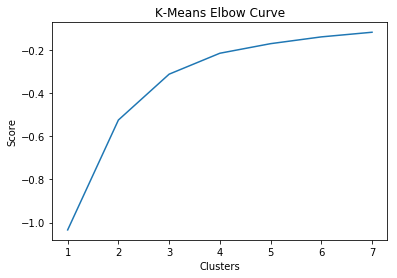

In [813]:
clusters = 8

X = filtered_venues.loc[:,['lat','lng']]

kmean_scores = []

for num in range(1,clusters):
    kmean = KMeans(n_clusters = num, random_state = 7)
    kmean.fit(X)
    
    kmean_scores.append(kmean.score(X))
    
plt.plot(range(1,clusters), kmean_scores)
plt.ylabel('Score')
plt.xlabel('Clusters')
plt.title('K-Means Elbow Curve')

### Elbow Plot Results

From the plot we can see the KMeans score appears to level off at around 3 clusters. This leveling indicates that adding more clusters will not help the classification of the points too much so we are best just using a simpler model. 

In [753]:
kmeans3 = KMeans(n_clusters = 3, random_state = 7)
kmeans3.fit(X)
borough3 = kmeans3.labels_
filtered_venues['borough3'] = borough3

In [754]:
print(filtered_venues['borough3'].value_counts())

2    481
0    363
1    265
Name: borough3, dtype: int64


In [755]:
WY_venues = generateMap("WY")

def color(clust):
    if  clust == 1:
        return 'green'
    elif clust == 2:
        return 'red'
    else:
        return 'blue'

# add markers to the map
for lat, lon, poi, cluster in zip(filtered_venues['lat'], filtered_venues['lng'], filtered_venues['type'], filtered_venues['borough3']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup = label,
        color=color(cluster),
        fill=True,
        fill_color=color(cluster),
        fill_opacity=0.7).add_to(WY_venues)
       
WY_venues

## The Groupings

From the graph we can see ther are 3 different "boroughs" that Sheraton can choose from. In order to find out which one will give our customers the best experience let's compare what venues each grouping contains.

In [784]:
group0 = filtered_venues[filtered_venues['borough3'] == 0]
group1 = filtered_venues[filtered_venues['borough3'] == 1]
group2 = filtered_venues[filtered_venues['borough3'] == 2]

## Important for Fun

Before we can go any further we need to decide which types of venues are enjoyable for people who are on vacation. This should give our tenants enough to do for a few days stay at our new hotel. We will see which area has the most of these and determine our winner from there. 

In [818]:
look = set(filtered_venues['type'])
look

{'ATM',
 'Accessories Store',
 'Advertising Agency',
 'Airport',
 'Airport Gate',
 'Airport Terminal',
 'American Restaurant',
 'Antique Shop',
 'Arcade',
 'Art Gallery',
 'Arts & Crafts Store',
 'Arts & Entertainment',
 'Asian Restaurant',
 'Assisted Living',
 'Athletics & Sports',
 'Auto Dealership',
 'Auto Workshop',
 'Automotive Shop',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Basketball Court',
 'Bed & Breakfast',
 'Beer Garden',
 'Beer Store',
 'Big Box Store',
 'Bike Shop',
 'Bookstore',
 'Boutique',
 'Bowling Alley',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Building',
 'Burger Joint',
 'Burrito Place',
 'Bus Station',
 'Bus Stop',
 'Business Service',
 'Café',
 'Campground',
 'Candy Store',
 'Capitol Building',
 'Car Wash',
 'Carpet Store',
 'Cemetery',
 'Chinese Restaurant',
 'Chiropractor',
 'Church',
 'City Hall',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'College Academic Building',
 'College Administrative Building',
 

In [824]:
fun_locations = filtered_venues.query('type in ["Bar", "Asian Restaurant", "Historic Site", "History Museum", "Pub", "Other Great Outdoors", "Beer Garden", "Bowling Alley", "Cocktail Bar", "Event Space", "Restaurant", "Winery", "American Restaurant", "Mexican Restaurant", "Park", "Museum", "Bakery", "Hotel", "Motel", "Coffee Shop"]')
fun_locations['type'].value_counts()

Hotel                   11
Bar                     11
American Restaurant     10
Coffee Shop             10
Mexican Restaurant      10
Park                     9
Bakery                   8
Restaurant               5
Motel                    5
Museum                   4
Asian Restaurant         4
Other Great Outdoors     4
Event Space              3
Historic Site            3
Bowling Alley            2
Winery                   2
Pub                      2
Cocktail Bar             2
Beer Garden              2
History Museum           1
Name: type, dtype: int64

In [825]:
group0_fun = fun_locations[fun_locations['borough3'] == 0]
group1_fun = fun_locations[fun_locations['borough3'] == 1]
group2_fun = fun_locations[fun_locations['borough3'] == 2]

## Group 0

In [875]:
group0_data = group0_fun.groupby('type').size().reset_index(name='counts').sort_values(by = 'counts', ascending = False)
group0_data['group'] = 0

,type,counts,group
8,Mexican Restaurant,5,0
1,Asian Restaurant,3,0
6,Coffee Shop,3,0
7,Hotel,3,0
0,American Restaurant,2,0
2,Bakery,2,0
3,Bar,2,0
5,Bowling Alley,2,0
9,Other Great Outdoors,2,0
10,Park,2,0


## Group 1

In [876]:
group1_data = group1_fun.groupby('type').size().reset_index(name='counts').sort_values(by = 'counts', ascending = False)
group1_data['group'] = 1


## Group 2

In [877]:
group2_data = group2_fun.groupby('type').size().reset_index(name='counts').sort_values(by = 'counts', ascending = False)
group2_data['group'] = 2

In [878]:
grouped_data = group0_data.append([group1_data, group2_data])

<Figure size 14400x14400 with 0 Axes>

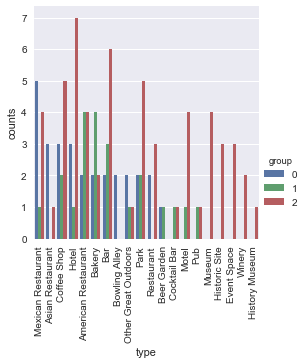

In [899]:
plt.figure(figsize = (200, 200))
gplot = sns.factorplot(x = 'type', y = 'counts', hue = 'group', data = grouped_data, kind = 'bar')
gplot.set_xticklabels(rotation = 90)

## Best Borough

After looking at the top 20 most prevalent venues in each area it appears to me the best area to build this hotel would be area 2. This has the most bars, museums, and restaurants in the area so the customers staying at our hotel will have lots to do. This location alos seems to be central in the city allowing for easy access to any other desirable attractions in the city. This 'borough' also seems to have the most hotels compared to others so clearly other companies thought the same thing. However with our discovered average rating of 6.2 per hotel this won't be an issue for a top tier organization like Sheraton. Now we will compare the different 'neighborhoods' within this borough to find which one will have the cheapest property cost. Since there is no readily available data for the respective neighborhoods of Cheyenne we will construct our own just using the zip codes given to each area.

In [790]:
group2['zipCode'].value_counts()

82001         305
82007          66
82009           4
82005           2
82002           1
82001-4199      1
Name: zipCode, dtype: int64

In [832]:
group2_neighbors = generateMap("WY", zoom = 13)

def zip_color(zipc):
    if  zipc == '82001':
        return 'green'
    elif zipc == '82007':
        return 'red'

for lat, lon, poi, zip_code in zip(group2['lat'], group2['lng'], group2['type'], group2['zipCode']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup = label,
        color=zip_color(zip_code),
        fill=True,
        fill_color=zip_color(zip_code),
        fill_opacity=0.7).add_to(group2_neighbors)
    
group2_neighbors

## Average Real Estate Prices

Attained from Realtor.com we will compare the median listing prices for property in Cheyenne.

In [792]:
neighborhoods = ['Historic Cheyene', 'Sun Valley', 'Western Hills', 'Saddle Ridge', 'Mountview Park', 'South Cheyenne', 'Indian Hills', 'Lake Minnehaha', 'Grandview Park', 'Alta Vista']
median_listing = [219, 274.9, 369, 355, 253.5, 185, 325, 188.5, 189.9, 232]
per_sq_ft = [131, 129, 141, 132, 139, 145, 126, 146, 145, 143]
housing_dict = {'Neighborhood':neighborhoods, 'Median Listings':median_listing, 'Median $/SqFt':per_sq_ft}
housing_data = pd.DataFrame(housing_dict)

Text(0.5,1,'Median House Listings')

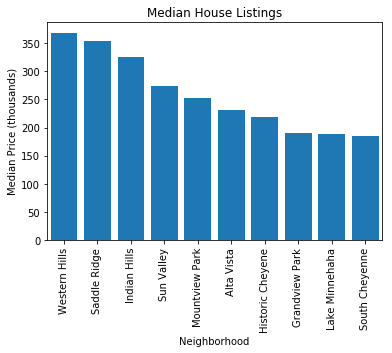

In [834]:
housing_data = housing_data.sort_values('Median Listings', ascending = False)

plt.bar(housing_data['Neighborhood'], housing_data['Median Listings'])
plt.ylabel("Median Price (thousands)")
plt.title('Median House Listings')

Text(0.5,0,'Neighborhood')

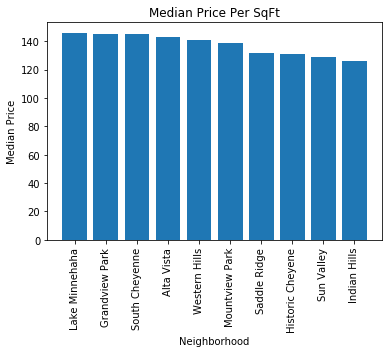

In [838]:
housing_data = housing_data.sort_values('Median $/SqFt', ascending = False)

plt.bar(housing_data['Neighborhood'], housing_data['Median $/SqFt'])
plt.ylabel("Median Price")
plt.title('Median Price Per SqFt')
plt.xticks(rotation = 90)
plt.xlabel('Neighborhood')

## The Best Neighborhood

Some venues do not have a zip code listed which are represented by the black dots but by looking at the graph its safe to say we can assume they fall into one of two categories. After looking at housing data from Realtor.com the median listing price for 'Historic Cheyenne' (green) is 219,000 and per square foot it is 131. However, for 'South Cheyenne' (red) the median listing price is 185,000 or 145 per square foot. Since hotels are historically large living areas finding a place in 'Historic Cheyenne' would be ideal as you save $10 per square foot. This area does also have the highest density of competing hotels and motels so space may be limited. However, since Cheyenne has a robust public transportation system if property is only available in 'South Cheyenne' then the hotel would still flourish.

In [845]:
group2_hotels = group2_fun.query('type == "Hotel" & zipCode == "82001"| type == "Motel" & zipCode == "82001"')

group2_hotels

,name,properties,lat,lng,zipCode,type,borough3
12,Sands Motel,"[{'id': '4bf58dd8d48988d1fb931735', 'name': 'M...",41.130018,-104.825118,82001,Motel,2
71,Microtel Inn & Suites,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",41.128145,-104.829664,82001,Hotel,2
77,Stage Coach Motel,"[{'id': '4bf58dd8d48988d1fb931735', 'name': 'M...",41.126540,-104.830063,82001,Motel,2
94,Hitching Post Inn Resort,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",41.126591,-104.833282,82001,Hotel,2
56,Historic Plains Hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",41.133324,-104.814554,82001,Hotel,2


In [846]:
group2_hotel_locations = generateMap("WY", zoom = 13)

for lat, lon, poi in zip(group2_hotels['lat'], group2_hotels['lng'], group2_hotels['type']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup = label,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.7).add_to(group2_hotel_locations)
    
group2_hotel_locations

## Best Locations

From the map showing where all the hotels and motels are in this ideal area it would appear that the best place for this hotel would be to the north of East 19th street or along East Lincolnway. This is of course assuming there is available space in those areas otherwise a different location would have to be found, but so long as the hotel is constructed within Cheyenne it will most likely do very well.

## Final Words

Cheyenne is a busy city full of history, scenic national parks, and a lively cultured nightlife. According to *Travel Wyoming* leisure and hospitality is the largest private sector employer in the state and hosted an estimated 8.9 million overnight tourists in 2018 alone. Becoming the best hotel in the most populated and most visited city in this growing state could lead to the Sheraton hotel bringing in an extremely large revenue from this one location alone. 